---
# Part 2, Figure 4
Water column presence and depths

---

This code requires output from code run on Compute Canada's HPC. For the purpose of this publication, this code has been placed in `../scripts/HPC_scripts/HPC_aggregate_mass_balance.py`

Package requirements are included in ../environment.yaml.  Install in the upper-level directory using:
```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]

**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created by Susan Allen with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/`
- a graphics style template in [../graphics_utils](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/publish/graphics_utils) was used.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import cmocean.cm as cm

# set colormap so it's white (water) and papayawhip (land)
my_cmap = matplotlib.colormaps['Greens'].copy()
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

# define directory paths
graphics_directory = Path('../')
# Aggregated files path
agg_dir = Path('../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/')
# graphics style
plt.style.use(r"../graphics_utils/style.template")

# predefined naming conventions
sys.path.append('../graphics_utils/')
import graphics_setup as graphics

# load aggregated results
oil = xr.open_dataset(agg_dir/f'fiftieth_55_oils.nc')

mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
tmask = 1- mesh_mask.tmaskutil[0]
mesh_mask.close()

%matplotlib inline

In [2]:
# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']

In [3]:
# define names used for Lagrangian files
oil_template_names = [
    'Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'
]
# define desired, end-product names for oil-types
oil_types = [
    'ANS','Bunker-C',
    'Diesel','Diesel',
    'Diesel','Dilbit', 
    'Bunker-C'
]
# for mapping of one dictionary key to a different dictionary key
key_map = {
    'akns':'ANS',
    'bunker':'Bunker-C',
    'diesel':'Diesel',
    'dilbit':'Dilbit' 
}

In [4]:
# Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

# trivial non-zero
eps = 1e-7

# N bootstraps
mcsize = 49

# create a masked array that shows where oil.deeppresence is not zero
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

# create masked array showing mean depth of oil dispersion where presence >= 50 spills
ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), oil.deeppresence < 50)

# Add eps to number of spills affecting water column (deeppresence) to mitigate divide by zero
#den = np.array(oil.deeppresence) + eps
den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)

# Standard error of dispersion depths     
location_ste = np.std(oil.deep_location[1:], axis=0, ddof=1) / np.sqrt(den)


In [5]:
location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (location_ste/(oil.deeppresence+eps) > absol) | (location_ste > perol*oil.deep_location[0]))) 

ma_location_ste = np.ma.masked_array(location_ste/(oil.deeppresence+eps), location_ste == 0)

# upper and lower limits corresponding to +/- 95% CI
upper_limit = np.array(ma_deep_location+1.975*location_ste)
lower_limit = np.array(ma_deep_location-1.975*location_ste)

ma_location_ste_2 = np.ma.masked_where(
    (np.array(oil.deeppresence)<50) | 
    (ma_deep_location < lower_limit) | 
    (ma_deep_location > upper_limit), 
    location_ste
)

wd_absol = absol
wd_perol = perol


In [6]:
# water column volume
ma_deep_oil = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0)

den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)
deepoil_ste = np.std(oil.deep_oil/(oil.deeppresence + eps), axis=0, ddof=1) / np.sqrt(den)
deepoiled = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (deepoil_ste > absol) )) 

ma_deepoil_ste = np.ma.masked_array(deepoil_ste, oil.deeppresence <= 0)

# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

dv_perol = perol

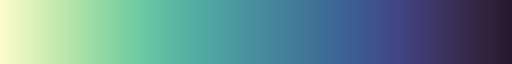

In [7]:
cm.deep.set_under('w')
cm.deep.set_over('k')
cm.deep

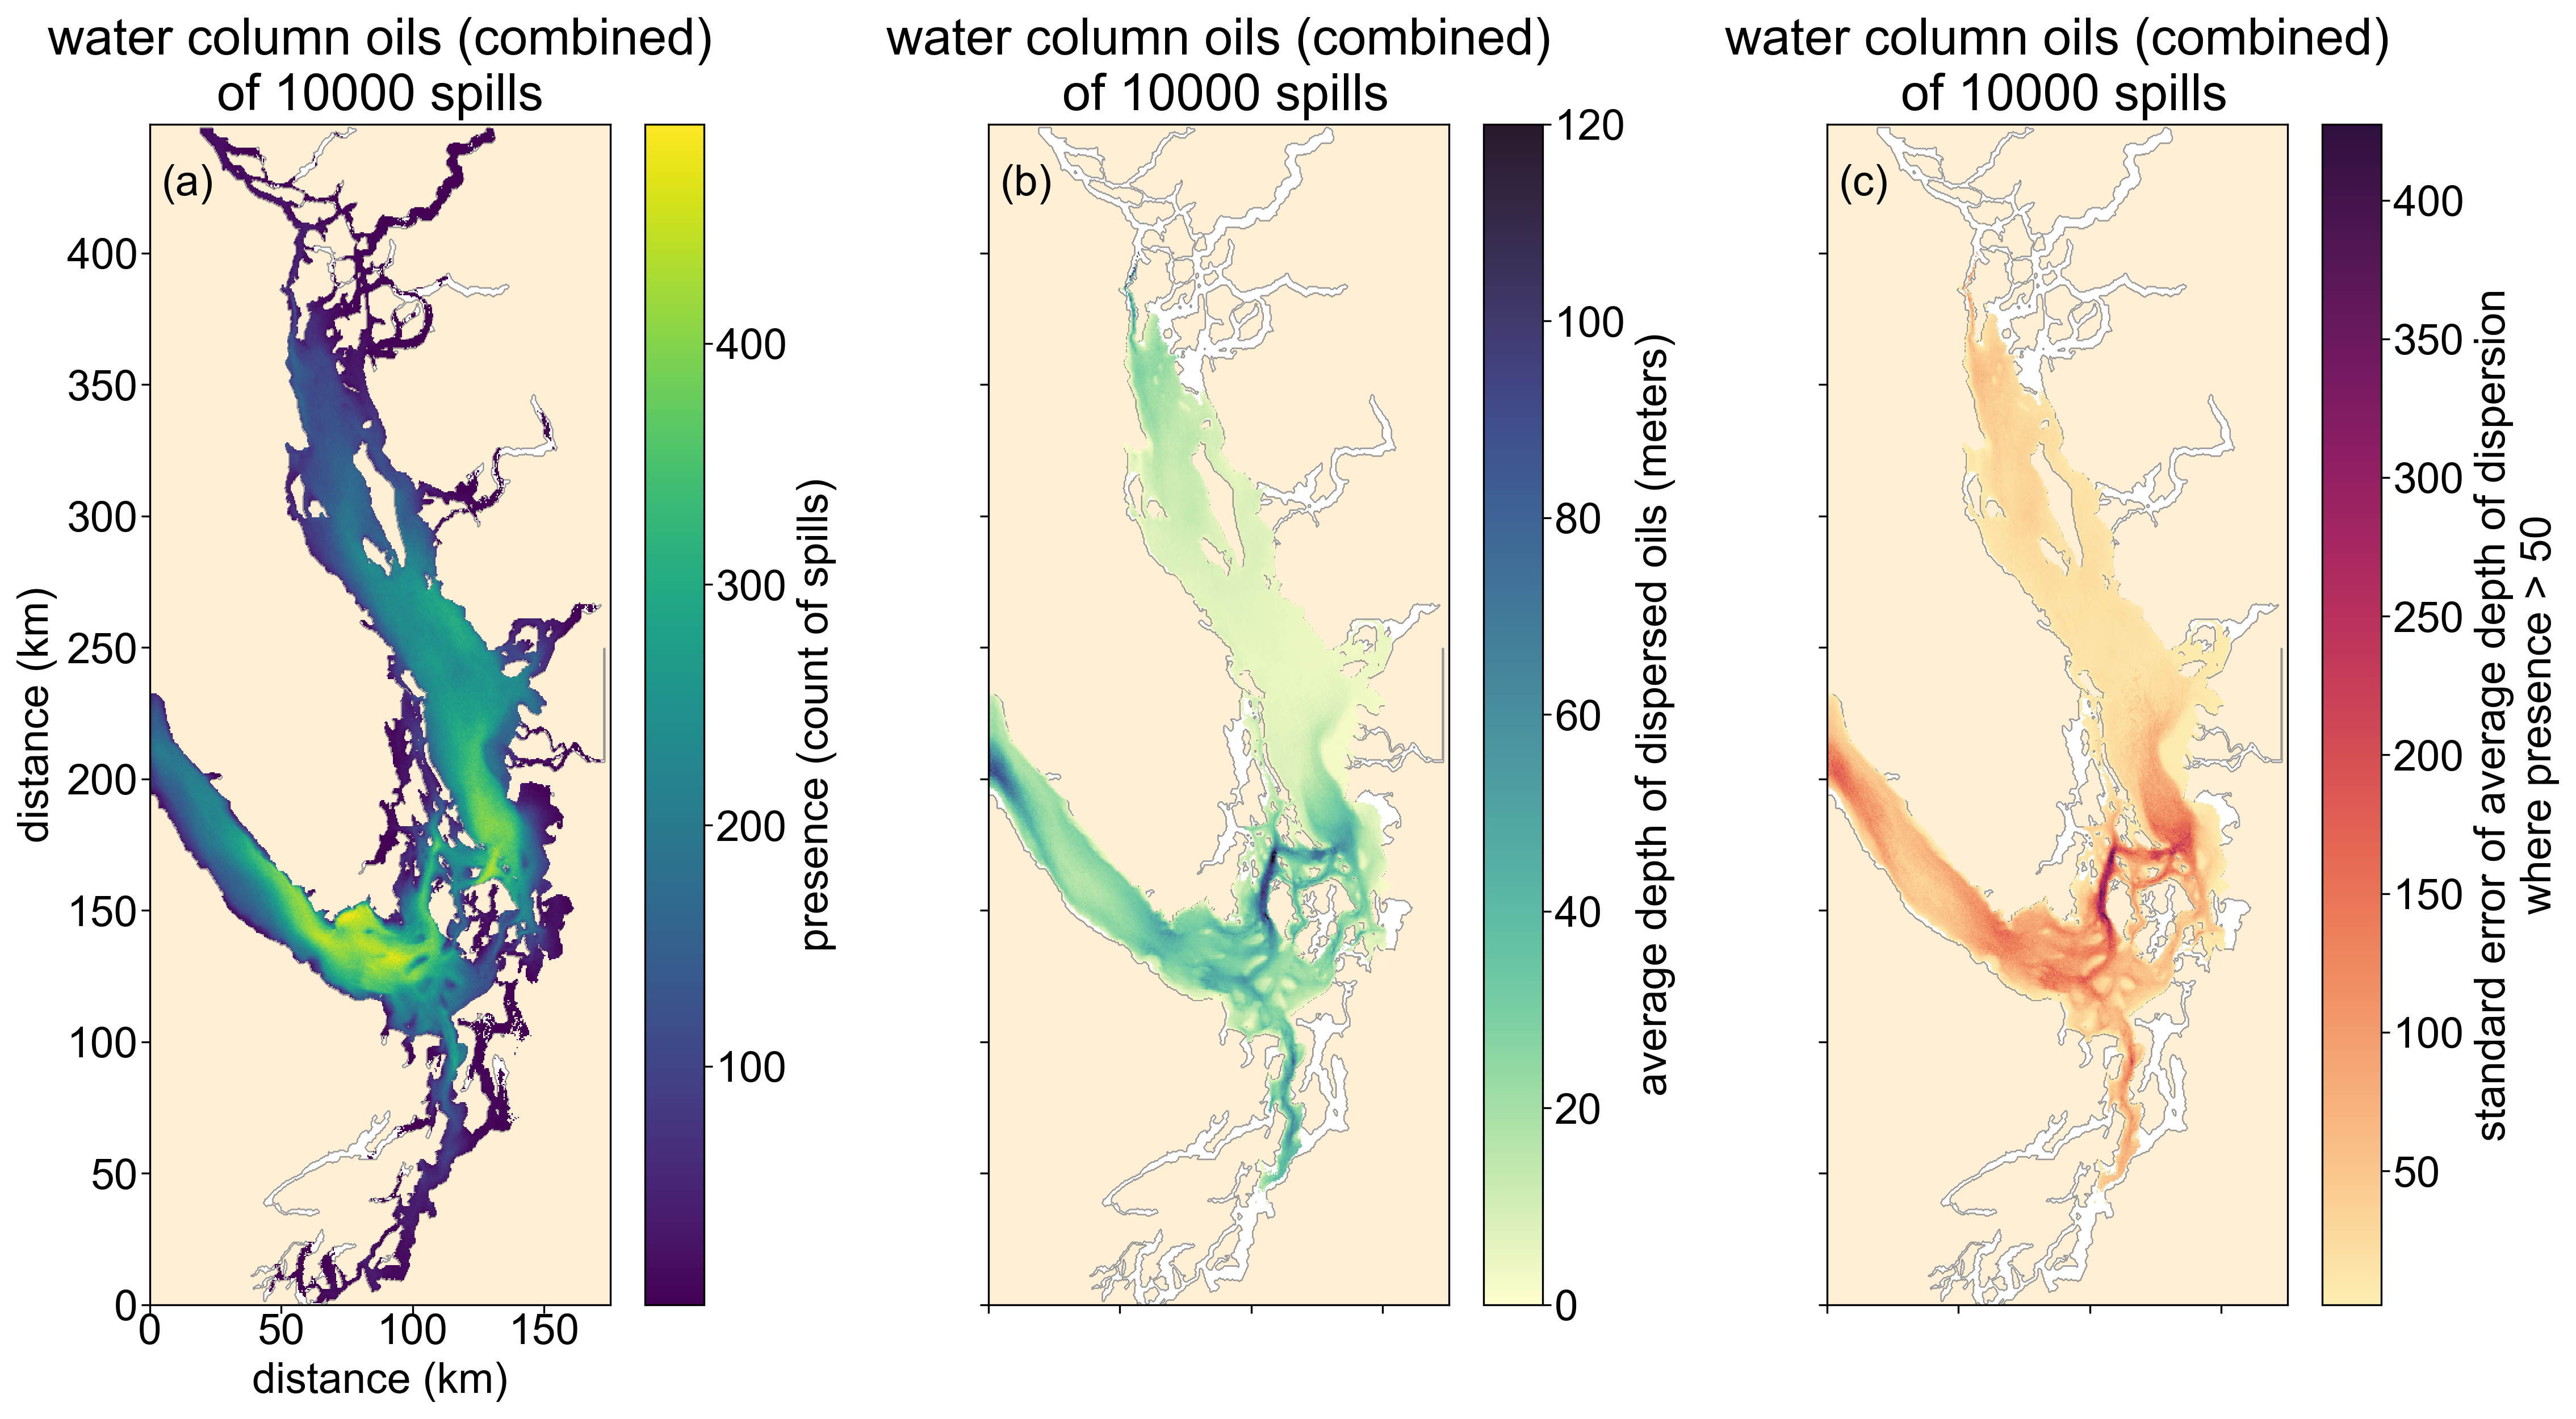

In [8]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440
smalloils = 113 + 54

fig, axs = plt.subplots(
    1, 3, 
    figsize=(18, 9), 
    gridspec_kw={'hspace': 0.0}
)

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=.1, vmax=.8)
    ax.contour(
        tmask[1:, 1:], 
        linewidths=graphics.shorelw, 
        colors=graphics.shoreline, alpha=.5
    )
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    # dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
    
C = axs[0].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title(f'water column oils (combined)\nof {oil.nofiles.values+smalloils} spills');   

C = axs[1].pcolormesh(
     ma_deep_location,
    zorder=2, vmin=0, vmax=120, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('average depth of dispersed oils (meters)')
axs[1].set_title(f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');

C = axs[2].pcolormesh(
     ma_location_ste_2,
    zorder=2, cmap=cm.matter
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('standard error of average depth of dispersion\nwhere presence > 50')
axs[2].set_title(f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');

# add suplot labels
subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig(graphics_directory/'Part2_Figure4_watercol_presence_all.png')